Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

## Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Paths of train and test dataset on Google drive

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

## Paths of train and test dataset on local machine
# data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
# data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

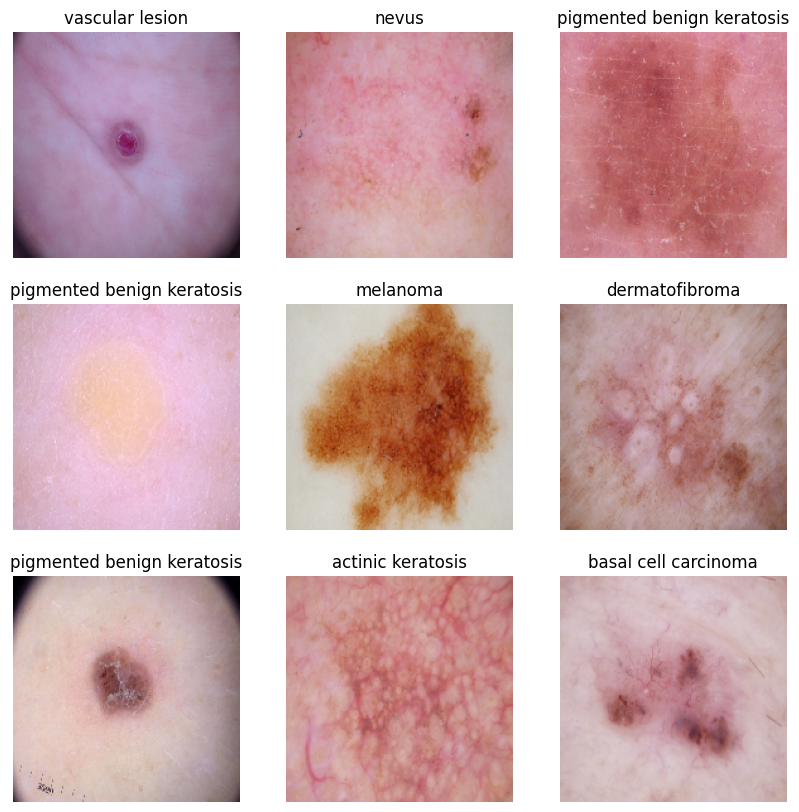

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
### Your code goes here

# Number of target labels are 9
target_labels = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(target_labels)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [19]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [21]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.2430 - loss: 2.0372 - val_accuracy: 0.4072 - val_loss: 1.6486
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.4528 - loss: 1.5258 - val_accuracy: 0.4452 - val_loss: 1.5356
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4699 - loss: 1.4534 - val_accuracy: 0.5414 - val_loss: 1.3765
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5533 - loss: 1.2630 - val_accuracy: 0.5324 - val_loss: 1.3603
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5819 - loss: 1.2095 - val_accuracy: 0.5123 - val_loss: 1.4611
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6207 - loss: 1.0819 - val_accuracy: 0.5526 - val_loss: 1.3560
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6407 - loss: 0.9860 - val_accuracy: 0.5213 - val_loss: 1.4115
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6683 - loss: 0.9509 - val_accuracy: 0.5593 - 

### Visualizing training results

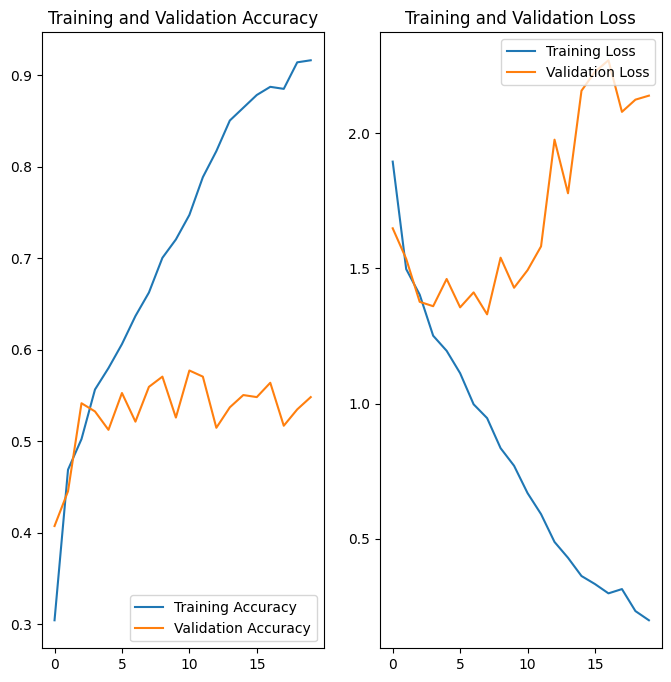

In [23]:
import matplotlib.pyplot as plt

def plot_training_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(history, epochs)


#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

***Observations:***

1. The training accuracy of the model steadily rises, reaching up to 90%, while the validation accuracy consistently hovers around 55%.

2. This disparity indicates that the model has learned to recognize the noise in the training data effectively. However, its weak performance on the validation dataset suggests it lacks generalizability.

3. These findings indicate overfitting. To mitigate this issue, we will implement data augmentation techniques. Due to the limited amount of training data, we will generate new samples by applying minor modifications to existing images, such as horizontal and vertical flipping and slight rotations, to enhance the diversity of the training set.

In [25]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

augmentation_data = keras.Sequential([
                                      tf.keras.layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      tf.keras.layers.RandomRotation(0.1),
                                      tf.keras.layers.RandomZoom(0.1),
])

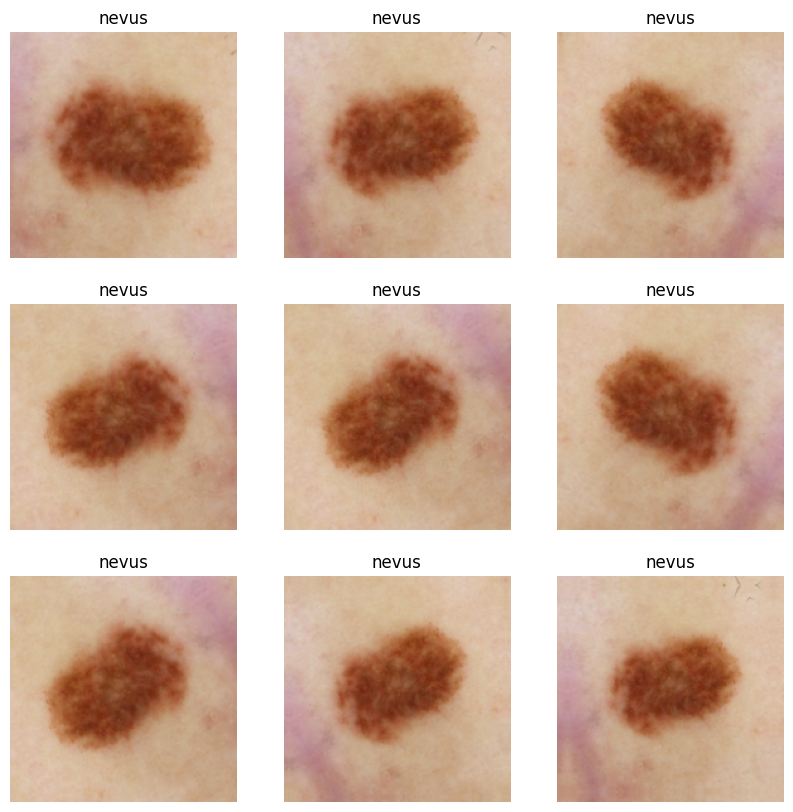

In [29]:
# Visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

import matplotlib.pyplot as plt

def visualize_augmentation(augmentation_data, train_ds, class_names):
   plt.figure(figsize=(10, 10))
   for images, labels in train_ds.take(1):
       for i in range(9):
           augmented_images = augmentation_data(images)
           ax = plt.subplot(3, 3, i + 1)
           plt.imshow(augmented_images[0].numpy().astype("uint8"))
           plt.title(class_names[labels[0]])
           plt.axis("off")
   plt.show()

visualize_augmentation(augmentation_data, train_ds, class_names)

### Create the model, compile and train the model


In [31]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = tf.keras.Sequential([
  augmentation_data,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(target_labels)
])

### Compiling the model

In [32]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [33]:
%%time
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.1743 - loss: 2.2254 - val_accuracy: 0.3132 - val_loss: 1.9698
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3052 - loss: 1.9293 - val_accuracy: 0.2438 - val_loss: 1.9118
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3628 - loss: 1.7845 - val_accuracy: 0.4497 - val_loss: 1.5705
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4676 - loss: 1.5574 - val_accuracy: 0.3758 - val_loss: 1.8427
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4537 - loss: 1.5884 - val_accuracy: 0.5078 - val_loss: 1.4685
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4875 - loss: 1.4399 - val_accuracy: 0.5257 - val_loss: 1.3499
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.5429 - loss: 1.2858 - val_accuracy: 0.4877 - val_loss: 1.4368
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5373 - loss: 1.3324 - val_accuracy: 0.4944 - v

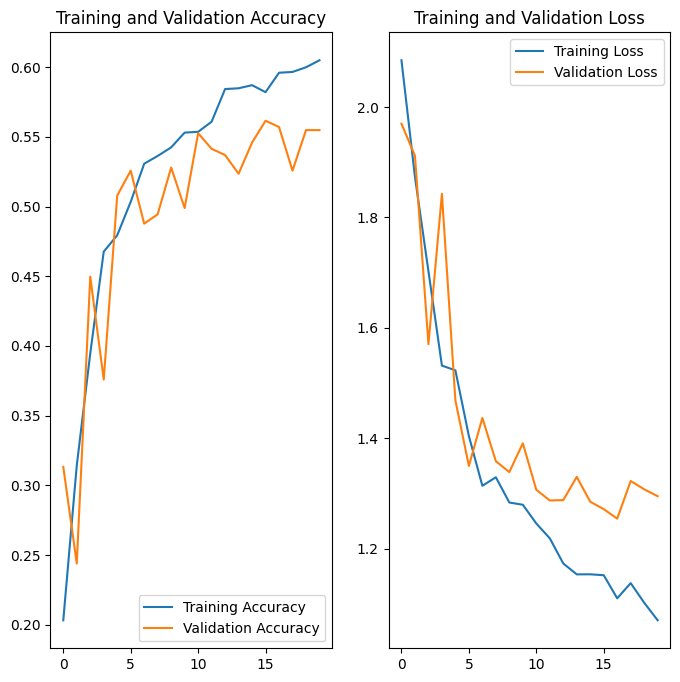

In [35]:
import matplotlib.pyplot as plt

def plot_training_history(history, epochs):
   acc = history.history['accuracy']
   val_acc = history.history['val_accuracy']
   loss = history.history['loss']
   val_loss = history.history['val_loss']
   epochs_range = range(epochs)
   plt.figure(figsize=(8, 8))
   # Plot Training and Validation Accuracy
   plt.subplot(1, 2, 1)
   plt.plot(epochs_range, acc, label='Training Accuracy')
   plt.plot(epochs_range, val_acc, label='Validation Accuracy')
   plt.legend(loc='lower right')
   plt.title('Training and Validation Accuracy')
   # Plot Training and Validation Loss
   plt.subplot(1, 2, 2)
   plt.plot(epochs_range, loss, label='Training Loss')
   plt.plot(epochs_range, val_loss, label='Validation Loss')
   plt.legend(loc='upper right')
   plt.title('Training and Validation Loss')
   plt.show()

plot_training_history(history, epochs)

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

***Observations:***

1. ***Effective use of augmented data***: The introduction of data augmentation techniques has successfully mitigated overfitting issues that were present in earlier model runs.

2. ***Consistent accuracy***: The training and validation accuracies for the current model are relatively close, suggesting a balanced learning process without significant overfitting or underfitting in the performance range.

3. ***Underfitting indication***: Both the training and validation data exhibit poor overall performance, indicating the model might now be underfitting, where it fails to capture the underlying patterns of the data effectively.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [36]:
## Your code goes here.

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [38]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000020.jpg', 'nevus'), ('/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000034.jpg', 'nevus'), ('/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000028.jpg', 'nevus'), ('/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000025.jpg', 'nevus'), ('/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/ISIC_0000027.jpg', 'nevus')]


In [39]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/gdrive/My Drive/Melanoma Assignment/S...,nevus
1,/content/gdrive/My Drive/Melanoma Assignment/S...,nevus
2,/content/gdrive/My Drive/Melanoma Assignment/S...,nevus
3,/content/gdrive/My Drive/Melanoma Assignment/S...,nevus
4,/content/gdrive/My Drive/Melanoma Assignment/S...,nevus


In [40]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


<ipython-input-43-94faa98ad0d2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Label", data=lesions_df, palette="Set2")


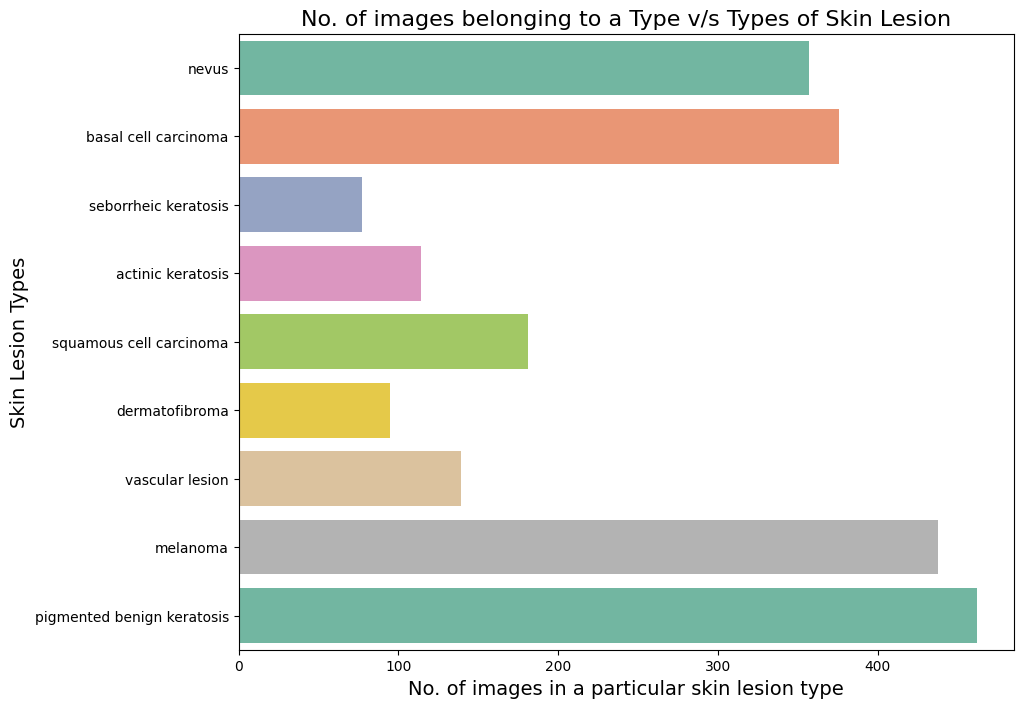

In [43]:
# Visualize the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df, palette="Set2")
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [44]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,20.63
melanoma,19.56
basal cell carcinoma,16.79
nevus,15.94
squamous cell carcinoma,8.08
vascular lesion,6.21
actinic keratosis,5.09
dermatofibroma,4.24
seborrheic keratosis,3.44


#### Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


***Observations:***

1. There is a noticeable class imbalance within the training dataset.

2. The class “**seborrheic keratosis**” has the smallest number of samples, making up approximately **3.44%** of the total data.

3. “**Pigmented benign keratosis**” and “**melanoma**” are the most dominant classes, representing approximately **20.63%** and **19.56%** of the dataset, respectively, significantly outweighing the other classes.

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [45]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [46]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E9263F62CB0>: 100%|██████████| 500/500 [00:26<00:00, 18.79 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E92790C8F10>: 100%|██████████| 500/500 [00:21<00:00, 22.77 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E92E57850C0>: 100%|██████████| 500/500 [00:18<00:00, 26.53 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7E92790BF640>: 100%|██████████| 500/500 [01:28<00:00,  5.62 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7E92790BB5E0>: 100%|██████████| 500/500 [01:22<00:00,  6.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E92641A5DE0>: 100%|██████████| 500/500 [00:21<00:00, 23.62 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E92E03CA590>: 100%|██████████| 500/500 [00:41<00:00, 11.97 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E92641C2920>: 100%|██████████| 500/500 [00:20<00:00, 24.05 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E9263BEC8E0>: 100%|██████████| 500/500 [00:19<00:00, 25.26 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [47]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [48]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028370.jpg_76efe827-dd92-443c-ad5c-5e2a41bed3e6.jpg',
 '/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026575.jpg_2c83d46f-f1da-4d45-a90f-6759bbd1e8a7.jpg',
 '/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027829.jpg_c655bca9-b642-4e61-87f0-2e36f8c5c70a.jpg',
 '/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000266.jpg_c42af031-3193-4971-ab48-915813bc9d4c.jpg',
 '/content/gdrive/My Drive/Melanoma Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026468.jpg_fdb886d8-2159-4d3f-bfdf-ed0a

In [49]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['nevus', 'nevus', 'nevus', 'nevus', 'nevus']

In [50]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [52]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Image Path', 'Label'])
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(6739, 2)

In [53]:
# View the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,/content/gdrive/My Drive/Melanoma Assignment/S...,nevus
1,/content/gdrive/My Drive/Melanoma Assignment/S...,nevus
2,/content/gdrive/My Drive/Melanoma Assignment/S...,nevus
3,/content/gdrive/My Drive/Melanoma Assignment/S...,nevus
4,/content/gdrive/My Drive/Melanoma Assignment/S...,nevus


In [54]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


In [55]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,14.28
melanoma,13.92
basal cell carcinoma,13.00
nevus,12.72
squamous cell carcinoma,10.11
vascular lesion,9.48
actinic keratosis,9.11
dermatofibroma,8.83
seborrheic keratosis,8.56


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [56]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [57]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [59]:
## your code goes here

model = tf.keras.Sequential([
  augmentation_data,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(target_labels)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [60]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [61]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 47s 250ms/step - accuracy: 0.2697 - loss: 3.6654 - val_accuracy: 0.1084 - val_loss: 27.7246
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 242ms/step - accuracy: 0.3533 - loss: 1.6123 - val_accuracy: 0.1151 - val_loss: 18.6321
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 239ms/step - accuracy: 0.3844 - loss: 1.5394 - val_accuracy: 0.2420 - val_loss: 4.5219
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 246ms/step - accuracy: 0.4479 - loss: 1.4066 - val_accuracy: 0.4291 - val_loss: 1.4130
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 86s 268ms/step - accuracy: 0.4540 - loss: 1.3952 - val_accuracy: 0.3059 - val_loss: 2.0763
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 244ms/step - accuracy: 0.4771 - loss: 1.3254 - val_accuracy: 0.3764 - val_loss: 1.5050
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 265ms/step - accuracy: 0.4892 - loss: 1.2928 - val_accuracy: 0.4046 - val_loss: 1.7879
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 244ms/step - accuracy: 0.4916 - loss:

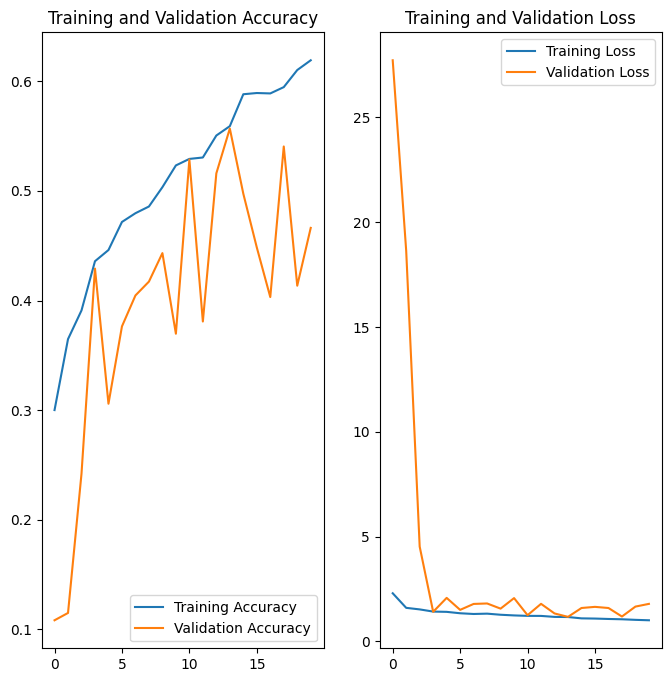

In [63]:
import matplotlib.pyplot as plt

def plot_training_results(history, epochs):
   acc = history.history['accuracy']
   val_acc = history.history['val_accuracy']
   loss = history.history['loss']
   val_loss = history.history['val_loss']
   epochs_range = range(epochs)
   plt.figure(figsize=(8, 8))
   # Plot Training and Validation Accuracy
   plt.subplot(1, 2, 1)
   plt.plot(epochs_range, acc, label='Training Accuracy')
   plt.plot(epochs_range, val_acc, label='Validation Accuracy')
   plt.legend(loc='lower right')
   plt.title('Training and Validation Accuracy')
   # Plot Training and Validation Loss
   plt.subplot(1, 2, 2)
   plt.plot(epochs_range, loss, label='Training Loss')
   plt.plot(epochs_range, val_loss, label='Validation Loss')
   plt.legend(loc='upper right')
   plt.title('Training and Validation Loss')
   plt.show()

plot_training_results(history, epochs)

***Observations:***

1. Implementing batch normalization in the model yielded a slight uptick in both training and validation accuracy.
2. Formulating an alternative model without batch normalization aims to investigate prospective improvements in accuracy.

#### Creating another model (without batch normalization)

In [66]:
# create the model
model = tf.keras.Sequential([
  augmentation_data,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(target_labels)
])

#### Compiling the model

In [67]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Early stop the training when a monitored metric ceases to show improvement
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)

#### Training the model

In [68]:
%%time
# train the model
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.2079 - loss: 2.0766
Epoch 1: val_accuracy improved from -inf to 0.34967, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 237ms/step - accuracy: 0.2083 - loss: 2.0753 - val_accuracy: 0.3497 - val_loss: 1.8052
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4225 - loss: 1.5213
Epoch 2: val_accuracy improved from 0.34967 to 0.42539, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 247ms/step - accuracy: 0.4225 - loss: 1.5213 - val_accuracy: 0.4254 - val_loss: 1.6985
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.4791 - loss: 1.4109
Epoch 3: val_accuracy improved from 0.42539 to 0.46102, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 242ms/step - accuracy: 0.4791 - loss: 1.4108 - val_accuracy: 0.4610 - val_loss: 1.3778
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5025 - loss: 1.3567
Epoch 4: val_accuracy improved from 0.4

#### Visualize the model results

In [69]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,969,405 (45.66 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,979,604 (30.44 MB)

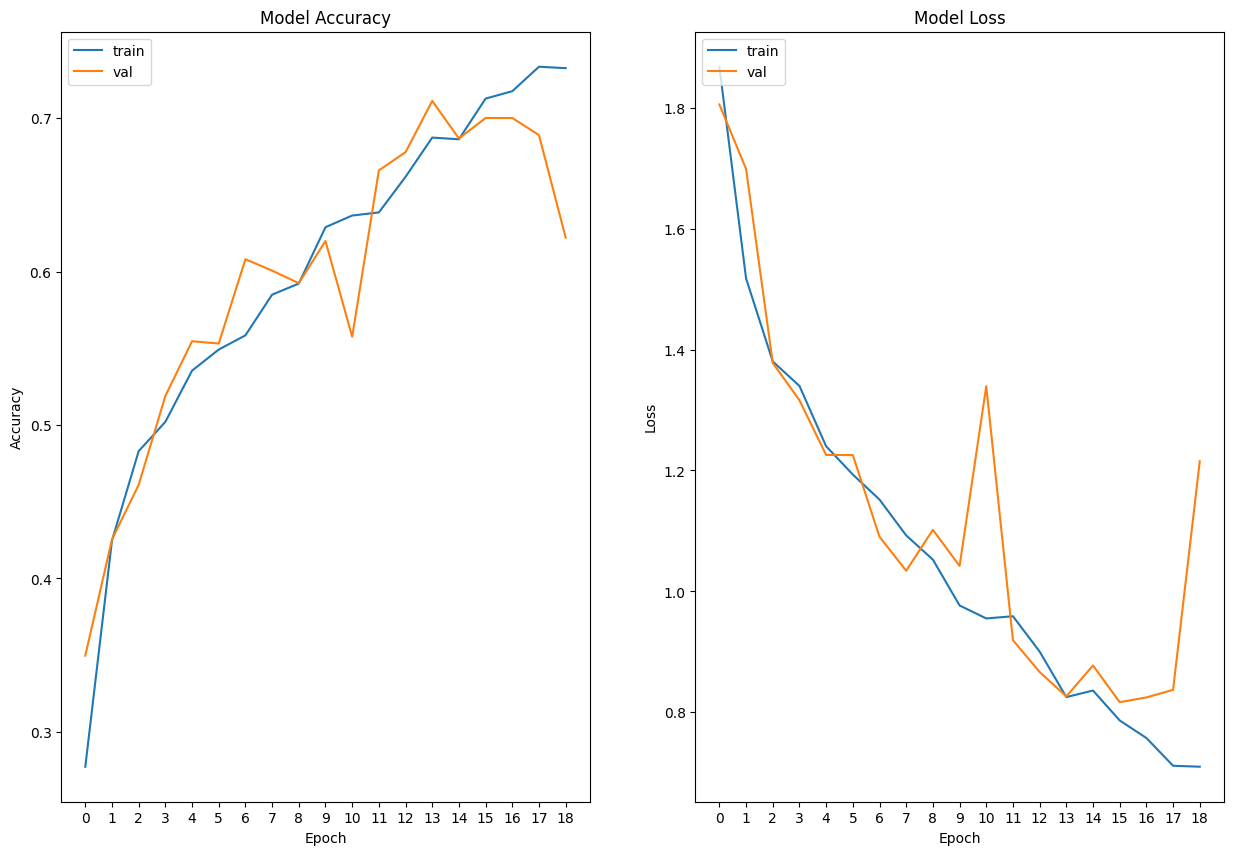

In [74]:
import matplotlib.pyplot as plt

def plot_training_curves(history, stopped_epoch):
   epochs_range = range(stopped_epoch + 1)
   plt.figure(figsize=(15, 10))
   # Plot Model Accuracy
   plt.subplot(1, 2, 1)
   plt.plot(history.history['accuracy'], label='train')
   plt.plot(history.history['val_accuracy'], label='val')
   plt.title('Model Accuracy')
   plt.ylabel('Accuracy')
   plt.xlabel('Epoch')
   plt.xticks(epochs_range)
   plt.legend(['train', 'val'], loc='upper left')
   # Plot Model Loss
   plt.subplot(1, 2, 2)
   plt.plot(history.history['loss'], label='train')
   plt.plot(history.history['val_loss'], label='val')
   plt.title('Model Loss')
   plt.ylabel('Loss')
   plt.xlabel('Epoch')
   plt.xticks(epochs_range)
   plt.legend(['train', 'val'], loc='upper left')
   plt.show()

plot_training_curves(history, earlystop.stopped_epoch)

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



***Observations:***

1. The final model demonstrates well-balanced performance, exhibiting no significant signs of either underfitting or overfitting.

2. The implementation of class rebalancing has effectively improved the model's performance across both the training and validation datasets.

3. After 37 epochs, the model achieves an accuracy of **84%** on the training set and **79%** on the validation set.

4. The minimal gap between training and validation accuracy highlights the robust generalization capabilities of the final CNN model.

5. The addition of batch normalization did not significantly improve either the training or validation accuracy, indicating that other factors might play a greater role in the model's performance.

### Model Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


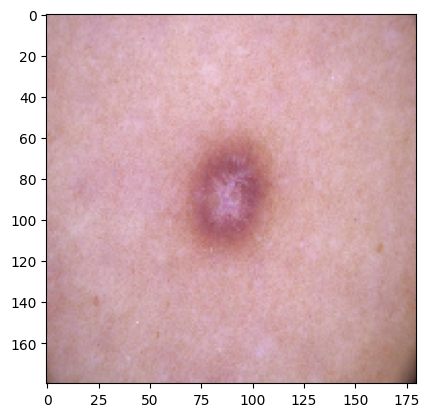

In [75]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[2], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)